In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns

# Time Series Tasks

### 1. Convert lbp to time series

In [108]:
data = pd.read_csv('patient_longitudinal.csv', delimiter='\t')

# reliable parsing
data['visit_date'] = pd.to_datetime(data['visit_date'], format='%Y-%m-%d')

# set key components and create series with datetimeindex
# clean duplicate
data = data.groupby(['visit_date']).mean().reset_index()
# data = data.drop_duplicates()

# create a pd.Series with DatatimeIndex using visit_date
data.set_index(data['visit_date'], inplace=True)
ts = pd.Series(data['bp_systolic'], index=data['visit_date'])

# consider timezone
ts_ny = ts.tz_localize('America/New_York')
ts_utc = ts_ny.tz_convert('UTC')

# Interpolate missing values
ts = ts.interpolate()
print(ts)

visit_date
2023-01-17    134.5687
2023-09-23    134.6433
2024-05-22    134.5201
2024-12-31    134.5247
Name: bp_systolic, dtype: float64


### 2. Analyze blood pressure

Text(0, 0.5, 'Values')

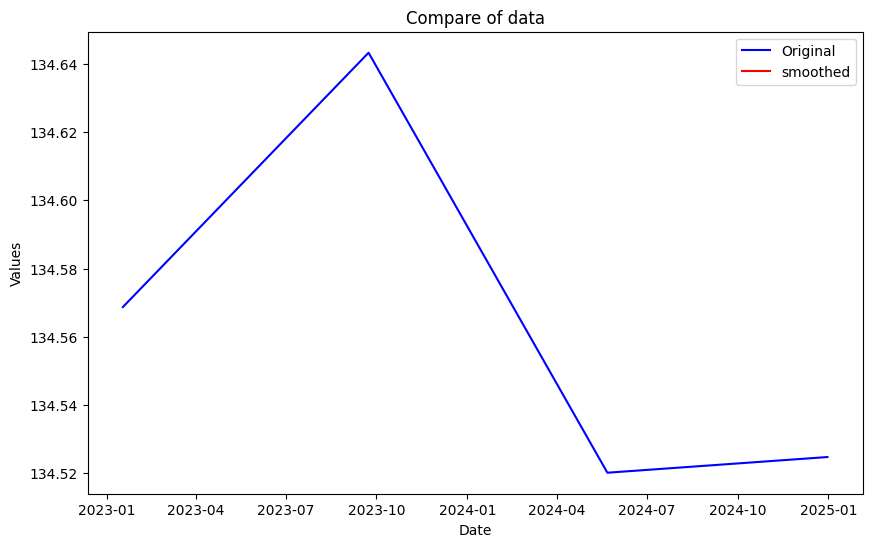

In [132]:
# resample to monthly
ts_mon = ts.resample('ME').mean()
# 3-month moving average
ts_3m = ts_mon.rolling(window=3, min_periods=2).mean()
# remove gaps
ts_3m = ts_3m.interpolate()
# exp
ts_3m.ewm(span=3, min_periods=2)
# visualize
plt.figure(figsize=(10, 6))
plt.plot(ts,label='Original', color='blue')
plt.plot(ts_3m,label='smoothed', color='red')
plt.title('Compare of data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Values')

# Statistical Modeling Task

### 1. Analyze factors

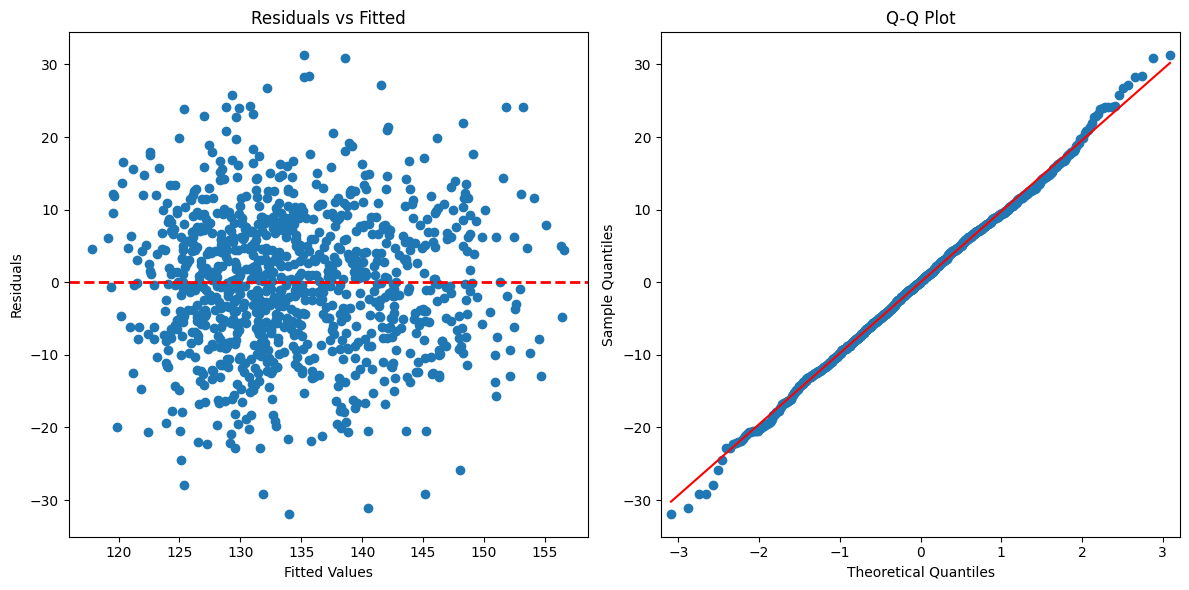

In [166]:
baseline = pd.read_csv('patient_baseline.csv', delimiter='\t')
y = baseline['bp_systolic']
X = baseline.drop(columns=['bp_systolic'])

# use OLS
X = sm.add_constant(X)
model = sm.OLS(y, X)
result = model.fit()
# Residuals vs Fitted values
plt.figure(figsize=(12, 6))

# Residuals vs Fitted
plt.subplot(1, 2, 1)
plt.scatter(result.fittedvalues, result.resid)
plt.axhline(0, linestyle='--', color='red', linewidth=2)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')

# Q-Q plot
plt.subplot(1, 2, 2)
sm.qqplot(result.resid, line='s', ax=plt.gca())
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

### 2. Model Treatment effectiveness

OR and CI:

             Odds Ratio       CI-       CI+
patient_id     0.999910  0.999460  1.000359
age            1.006348  0.995838  1.016969
sex            0.896865  0.691197  1.163731
bmi            0.985786  0.958502  1.013846
smoking        0.741471  0.484178  1.135488
diabetes       0.624828  0.433739  0.900103
bp_systolic    1.002753  0.992211  1.013407
cholesterol    1.000782  0.995117  1.006478
heart_rate     0.983331  0.971822  0.994976
adherence      2.610439  0.812678  8.385105
Residual Deviance: 1296.5061
Null Deviance: 1334.7744


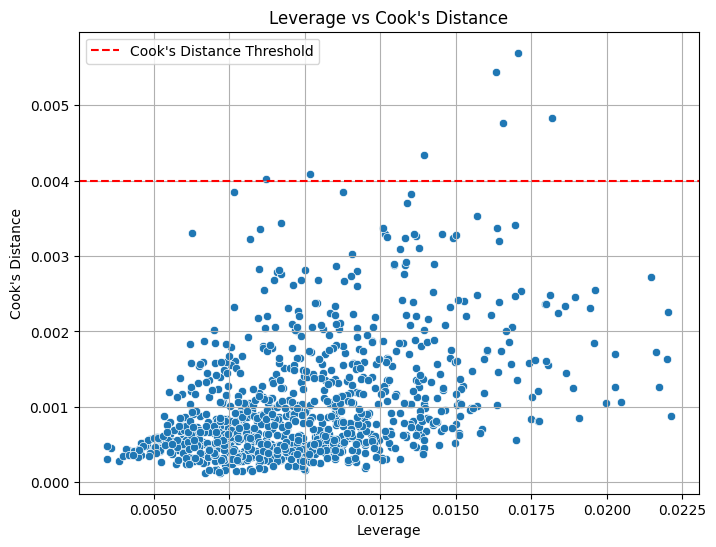

In [221]:
treatment = pd.read_csv('patient_treatment.csv', delimiter='\t')
# Get all column names in df1
col_treatment = treatment.columns.tolist()

# Find common column names in df2
vae = [col for col in col_treatment if col in baseline.columns]
vae.append('adherence')
y = treatment['outcome']
X = treatment[vae]
model2 = sm.GLM(y, X, family=sm.families.Binomial())
results = model2.fit()

# report odds ratios and CI
odds = np.exp(results.params)
conf = np.exp(results.conf_int())

odds_ratios_df = pd.DataFrame({
    'Odds Ratio': odds,
    'CI-': conf[0],
    'CI+': conf[1]
})

print("OR and CI:\n")
print(odds_ratios_df)

# check residual deviance vs null deviance
rd = results.deviance
null = results.null_deviance

print(f"Residual Deviance: {rd:.4f}")
print(f"Null Deviance: {null:.4f}")

# get influential observation
influence = results.get_influence()
leverage = influence.hat_matrix_diag
cooks = influence.cooks_distance[0]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=leverage, y=cooks)
plt.axhline(y=4 / len(y), linestyle='--', color='red', label='Cook\'s Distance Threshold')
plt.grid()
plt.xlabel('Leverage')
plt.ylabel("Cook's Distance")
plt.title("Leverage vs Cook's Distance")
plt.legend()
plt.show()

# Machine Learning Task

### 1. build prediction pipline

In [265]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay


# Create ColumnTransformer to handle preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['patient_id', 'age', 'bmi', 'bp_systolic', 'cholesterol', 'heart_rate', 'adherence']), 
        ('cat', OneHotEncoder(), ['sex', 'smoking', 'diabetes']) 
    ]
)

# Create pipeline with specific components
pipeline = make_pipeline(
    preprocessor,
    StandardScaler(),
    SelectKBest(k=5),
    LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced'
    )
)



### 2. validate model performance

Cross-Validated Accuracy: 0.56
Cross-Validated Precision: 0.45
Cross-Validated Recall: 0.60
Cross-Validated ROC AUC: 0.61
confusion matrix:
[[97 87]
 [47 69]]

classification report:
              precision    recall  f1-score   support

           0       0.67      0.53      0.59       184
           1       0.44      0.59      0.51       116

    accuracy                           0.55       300
   macro avg       0.56      0.56      0.55       300
weighted avg       0.58      0.55      0.56       300




<Figure size 800x600 with 0 Axes>

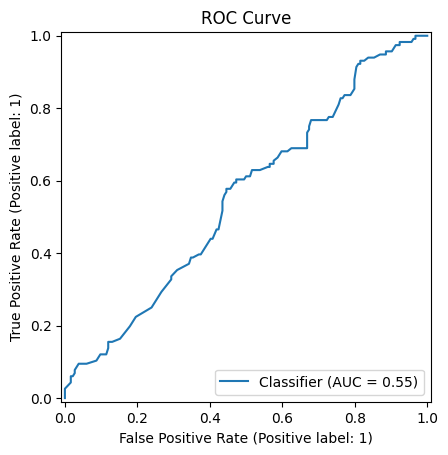

In [269]:
# Stratified split for imbalanced data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y,
    random_state=42
)

# Cross-validation with multiple metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc']
)

# scores
print(f'Cross-Validated Accuracy: {np.mean(scores['test_accuracy']):.2f}')
print(f'Cross-Validated Precision: {np.mean(scores['test_precision']):.2f}')
print(f'Cross-Validated Recall: {np.mean(scores['test_recall']):.2f}')
print(f'Cross-Validated ROC AUC: {np.mean(scores['test_roc_auc']):.2f}')

# prediction
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# results
print(f"confusion matrix:\n{confusion_matrix(y_test, y_pred)}\n")
print(f"classification report:\n{classification_report(y_test, y_pred)}\n")
y_pred_pos = pipeline.predict_proba(X_test)[:, 1]
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, y_pred_pos)
plt.title('ROC Curve')
plt.show()